In [1]:
%load_ext autoreload
%autoreload 2

import sys
import string

from flowmaps.flowmaps import FlowMaps

import pytz
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_date(date_strn):
    date = datetime.strptime(date_strn, '%Y-%m-%d')
    start_summer_time = datetime(date.year, 3, 29)
    end_summer_time = datetime(date.year, 10, 25)
    if start_summer_time <= date <= end_summer_time:
        delta_h = timedelta(hours=2)
    else:
        delta_h =  timedelta(hours=1)
    date -= delta_h
    return date

def RMSE(x, y):
    return np.sqrt(((x - y) ** 2).mean())

## Validate estimated population

In [3]:
tz = pytz.timezone('Europe/Madrid')

mongodb_params = {
    "host": ['mdb-login.bsc.es:27017'],
    "username":'flowmaps_ro',
    "password": 'ifB8e2ECz7EFK5a4Jyja',
    "authSource": 'FlowMaps'
}

fm = FlowMaps(mongodb_params)

query = fm.data('cnig.municipios')
pipeline = [{'$project': {'_id': 0, 'cod_ine': 1, 'cod_prov': 1, 'provincia': 1,
                          'poblacion_muni': 1, 'id': { '$substr': ['$cod_ine', 0, 5] }}}]

query = query.add_steps(pipeline)
df_cnig_pop = query.get().to_df()
df_cnig_pop = df_cnig_pop.set_index('id')

In [4]:
municip_ids = fm.layer('cnig_municipios').add_steps([{'$project': {'_id': 0, 'id': 1}}]).get().to_df().id.tolist()
mitma_ids = fm.layer('mitma_mov').add_steps([{'$project': {'_id': 0, 'id': 1}}]).get().to_df().id.tolist()

cursor = fm.overlaps('mitma_mov', 'cnig_municipios').get()
O_mit2muni_area = cursor.to_matrix(row_ids=mitma_ids, col_ids=municip_ids)

cursor = fm.overlaps('mitma_mov', 'cnig_municipios', collection='layers.overlaps_population').get()
O_mit2muni_popgrid = cursor.to_matrix(row_ids=mitma_ids, col_ids=municip_ids)

In [5]:
# Querying population from MITMA zones
date = get_date('2020-02-15')
query = fm.data('mitma_mov.zone_movements').filter({'evstart' : date})
query = query.add_steps([{'$project': {'_id': 0, 'id': 1, 'personas': 1}}])
df_mitma_pop = query.get().to_df().groupby(['id']).sum()

# adding zones with zero poopulations
zero_pop_mitma_zones = set(mitma_ids) - set(df_mitma_pop.index)
df = pd.DataFrame(np.zeros(len(zero_pop_mitma_zones)),index=zero_pop_mitma_zones, columns=['personas'])
df_mitma_pop = df_mitma_pop.append(df)
df_mitma_pop = df_mitma_pop.loc[mitma_ids]

In [6]:
# Overlaps based areas
proj_pop_area =(O_mit2muni_area.T * df_mitma_pop).T[0]
proj_pop_area = pd.Series(proj_pop_area, index=municip_ids)
proj_pop_area = proj_pop_area[df_cnig_pop.index]

df_area = pd.DataFrame({'MITMA': proj_pop_area.values, 
                        'INE': df_cnig_pop['poblacion_muni'].values})

# Overlaps based on population grid
proj_pop_popgrid =(O_mit2muni_popgrid.T * df_mitma_pop).T[0]
proj_pop_popgrid = pd.Series(proj_pop_popgrid, index=municip_ids)
proj_pop_popgrid = proj_pop_popgrid[df_cnig_pop.index]

df_population = pd.DataFrame({ 'MITMA_area': proj_pop_area.values, 
                               'MITMA_grid': proj_pop_popgrid.values, 
                               'INE': df_cnig_pop['poblacion_muni'].values})

Resiudals 1240.245926989199
R-squared: 0.999050
238.069211013114 0.9400814652747328
1.00  0.00E+00  3163.05
Resiudals 858.3199402783697
R-squared: 0.999603
202.68497099615251 0.9482965700589596
1.00  0.00E+00  2616.16


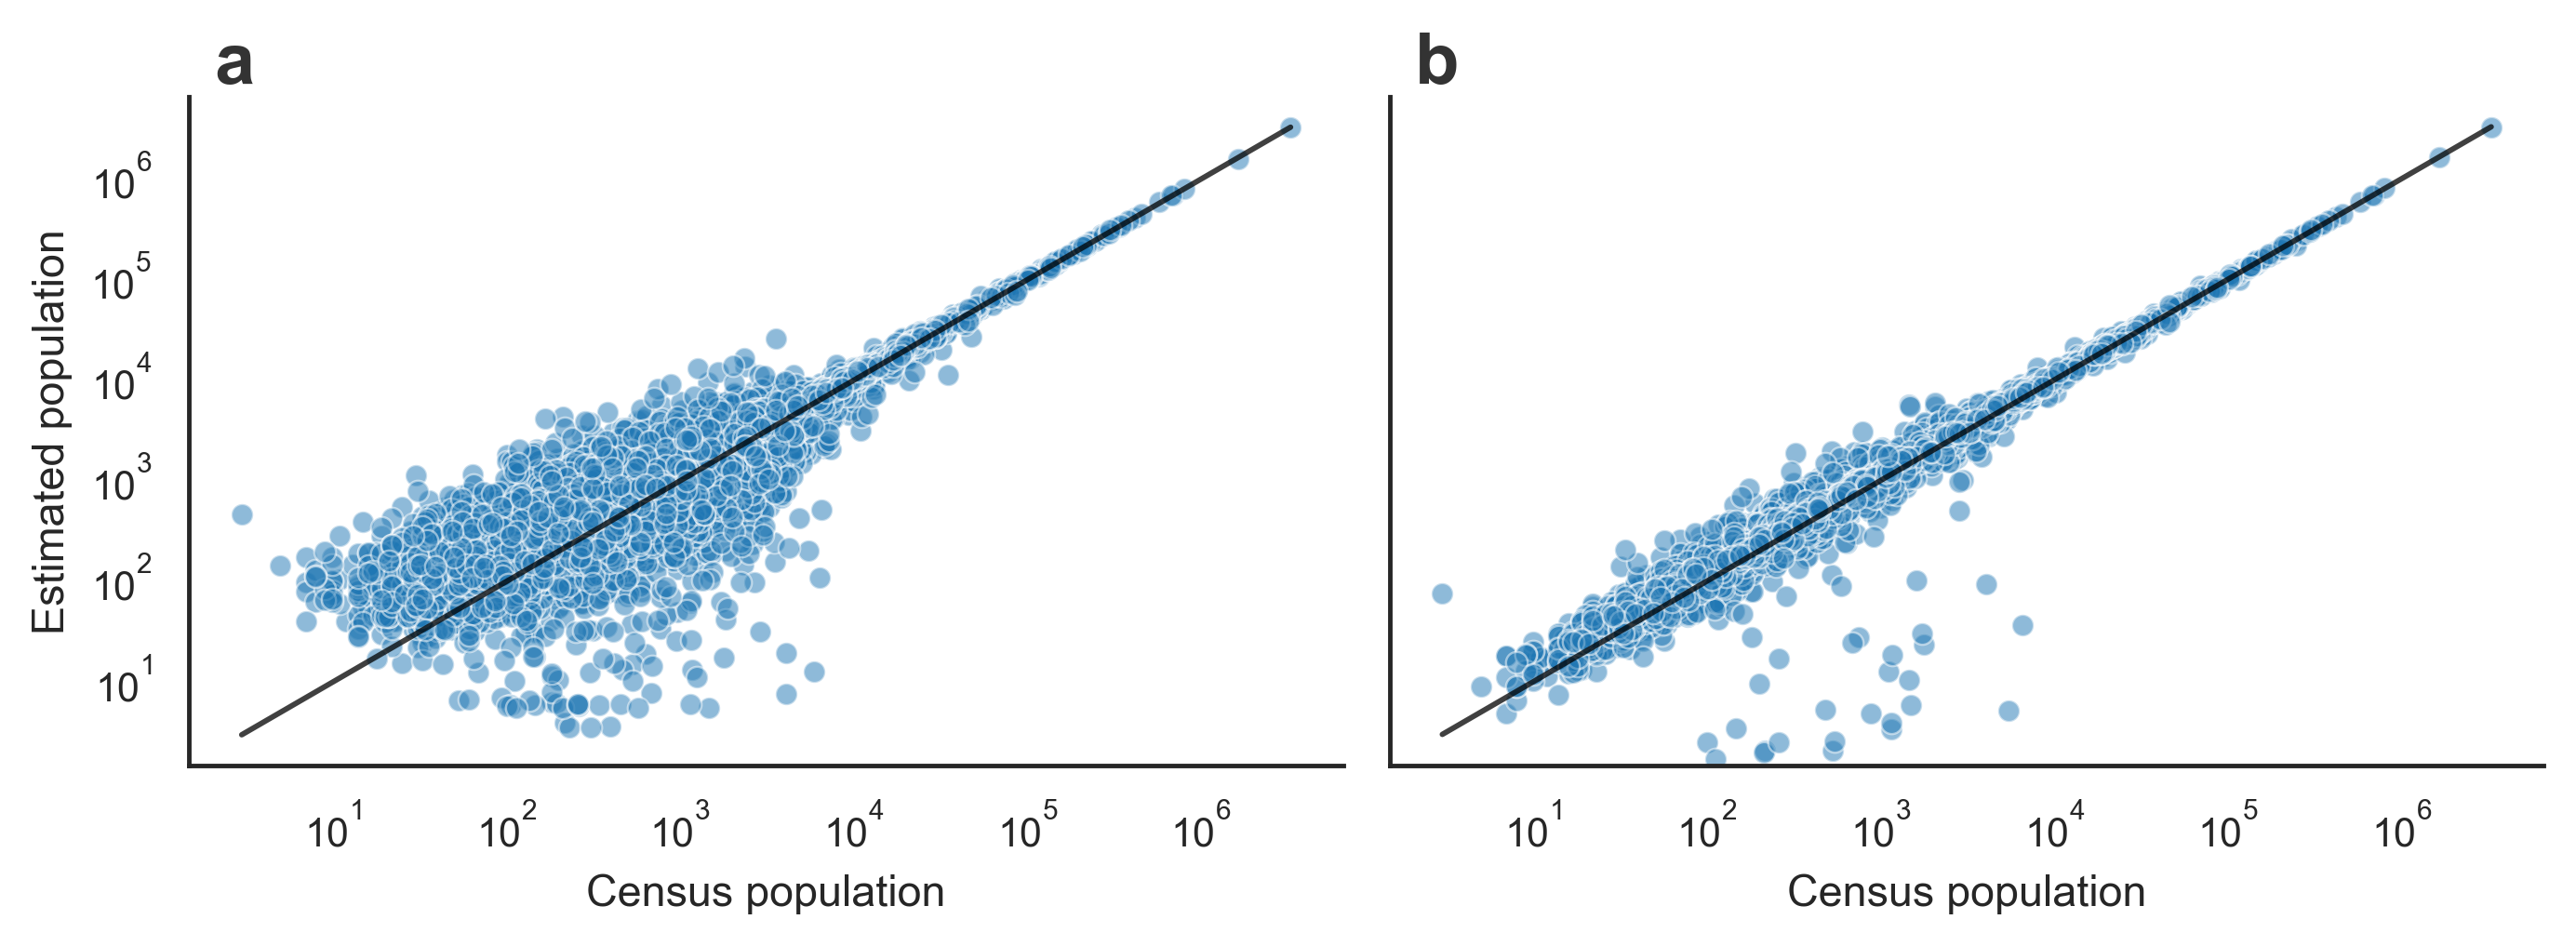

In [7]:
sns.set_style('white')
sns.set_context('paper')

fig, axes = plt.subplots(1,2, figsize=(8,3), dpi=350, sharex=True, sharey=True)
for i, k in enumerate(['MITMA_area', 'MITMA_grid']):
    
    X = df_population['INE'].values
    y = df_population[k].values
    
   
    r, p = pearsonr(X, y)
    res = linregress(X, y)
    y_predicted = X * res.slope
    residuals = np.abs(y-y_predicted)
    rmse = RMSE(df_population['INE'], df_population[k])
    
    print("Resiudals", np.std(residuals))
    print(f"R-squared: {res.rvalue**2:.6f}")
    print(res.intercept, res.slope)
    print("%.2f  %.2E  %.2f" % (r, p, rmse))

    ax = axes[i]
    ax.scatter(X, y, alpha=0.5, edgecolor='w', linewidth=0.5)
    ax.plot(sorted(X), sorted(y_predicted), c='k', alpha=0.75)
    ax.set(xscale="log", yscale="log")
    ax.set_xlabel('Census population')
    ax.text(0.022, 1.02, string.ascii_lowercase[i], fontsize=16, 
            transform=ax.transAxes, weight='bold', color='#333333')
    if i == 0:
        ax.set_ylabel('Estimated population')
    

fig.tight_layout()
sns.despine(fig)